## Identifying COVID-19 Infection with Residual Convolution Networks
December 2021 $\\$
Author: Matthew Rossi

In this notebook, I train three ResNet-style convolutional neural networks on a binary classification computer vision tasks. The dataset contains CT scans of lungs of patients with and without COVID-19 infection, with each image labeled as such.  
The three CNNs I train are:  
1. a custom ResNet-style CNN that I programmed, which isn't as deep as ResNet18.
2. A ResNet18, imported from torchvision but trained from scratch.  
    a. The classifier head has been replaced to output a single value instead of 1000.
3. A ResNet18, imported from torchvision and loaded with parameters from pretraining on the ImageNet dataset.  
    a. All layers were frozen so no parameter updates could be made.  
    b. The classifier head has been replaced to output a single value instead of 1000.
    c. I fine-tuned the classifier head.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import pandas as pd

class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I = io.imread(self.path+self.filenamelist[idx])
        I = skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2]) #copy the single channel to make three channels for input to CNNs
        label=torch.tensor(int(self.labellist[idx]), dtype=torch.int64)
        return I, label

def get_dataloader(dataset_type='train'):
    path='S224/'
    df=pd.read_csv(path+dataset_type+'.csv')
    dataset = MyDataset(path, df['filename'].values, df['label'].values)
    loader = torch_dataloader(dataset, batch_size=32, shuffle=True, pin_memory=True)
    return loader

In [2]:
train_loader = get_dataloader('train')
val_loader = get_dataloader('val')
test_loader = get_dataloader('test')

In [3]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train = 0
    acc_train = 0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Z = model(X) #forward pass
        Z = Z.view(-1)
        loss = F.binary_cross_entropy_with_logits(Z, Y.float()) #compute loss
        loss.backward() #backward pass
        optimizer.step() #update parameters
        loss_train+=loss.item() #record the loss
        #make prediction, do not need sigmoid
        Yp = (Z.data>0).to(torch.int64)    
        #measure accuracy on this batch
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()), end='\r')
    print()
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset)
    return loss_train, acc_train

def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0 
    with torch.no_grad(): # tell Pytorch not to build graph in this section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            Z = Z.view(-1)
            loss = F.binary_cross_entropy_with_logits(Z, Y.float())    
            loss_test+=loss.item()
            #make prediction, do not need sigmoid
            Yp = (Z.data>0).to(torch.int64) 
            acc_test+= torch.sum(Yp==Y).item()
    loss_test/=len(dataloader)    
    acc_test/=len(dataloader.dataset)
    return loss_test, acc_test

In [4]:
def save_checkpoint(filename, model, optimizer, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
               filename)
    print('saved:', filename)
    
def load_checkpoint(filename, model, optimizer, device):
    checkpoint=torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None: #may not need optimizer if we just want to use model for inference
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [5]:
def train_model(model, filename, initial_lr=1e-2, l2_regularization=0.05, milestones=[6,11,15,25], epochs=25):
    loss_train_list=[]
    loss_val_list=[]
    acc_train_list=[]
    acc_val_list=[]

    #prepare training
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    
    best_acc_val = 0
    for epoch in range(epochs):    
        #-------- perform training --------------------------------
        loss_train, acc_train = train(model, optimizer, train_loader, device, epoch)
        loss_train_list.append(loss_train)
        acc_train_list.append(acc_train)
        scheduler.step()
        print('epoch %d training loss: %1.4f acc: %2.2f%%' % (epoch, loss_train, acc_train*100))
        #-------- perform validation --------------------------------
        loss_val, acc_val = test(model, val_loader, device)
        loss_val_list.append(loss_val)
        acc_val_list.append(acc_val)
        print('epoch %d validation loss: %1.4f acc: %2.2f%%' % (epoch, loss_val, acc_val*100))
        #------ save model ------------------
        if acc_val >= best_acc_val:
            save_checkpoint(filename, model, optimizer, epoch)
            best_acc_val = acc_val
    
    return loss_train_list, loss_val_list, acc_train_list, acc_val_list

In [6]:
from torchvision.models import resnet18
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
#my custom ResNet-style architecture
class Block(nn.Module):
    def __init__(self,depth):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(depth,depth,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(depth,depth,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
  
    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x += res
        x = F.relu(x)
        x = self.pool(x)
        return x

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1)
        self.block1 = Block(16)
        self.block2 = Block(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        self.block3 = Block(32)
        self.block4 = Block(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.block5 = Block(64)
        self.block6 = Block(64)
        self.fc1 = nn.Linear(32*14*14, 256)
        self.fc2 = nn.Linear(256, 1)
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.block3(x)
        x = self.block4(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = x.view(-1)
        return z

In [10]:
print("Training custom network from scratch:")
model = MyNet()
model.to(device)
model_lists = train_model(model, "custom_model.pt", initial_lr=1e-4, l2_regularization=0.0)

Training custom network from scratch:
Train Epoch: 0 [1920/2022 (94%)]	Loss: 0.686905
epoch 0 training loss: 0.6882 acc: 57.57%
epoch 0 validation loss: 0.6830 acc: 51.67%
saved: custom_model.pt
Train Epoch: 1 [1920/2022 (94%)]	Loss: 0.616034
epoch 1 training loss: 0.6440 acc: 62.17%
epoch 1 validation loss: 0.6468 acc: 60.00%
saved: custom_model.pt
Train Epoch: 2 [1920/2022 (94%)]	Loss: 0.409551
epoch 2 training loss: 0.5965 acc: 72.70%
epoch 2 validation loss: 0.6430 acc: 68.33%
saved: custom_model.pt
Train Epoch: 3 [1920/2022 (94%)]	Loss: 0.611416
epoch 3 training loss: 0.5758 acc: 75.27%
epoch 3 validation loss: 0.6876 acc: 56.67%
Train Epoch: 4 [1920/2022 (94%)]	Loss: 0.506175
epoch 4 training loss: 0.5603 acc: 77.84%
epoch 4 validation loss: 0.7279 acc: 55.00%
Train Epoch: 5 [1920/2022 (94%)]	Loss: 0.524568
epoch 5 training loss: 0.5410 acc: 79.72%
epoch 5 validation loss: 0.6641 acc: 63.33%
Train Epoch: 6 [1920/2022 (94%)]	Loss: 0.447757
epoch 6 training loss: 0.5124 acc: 82.29%

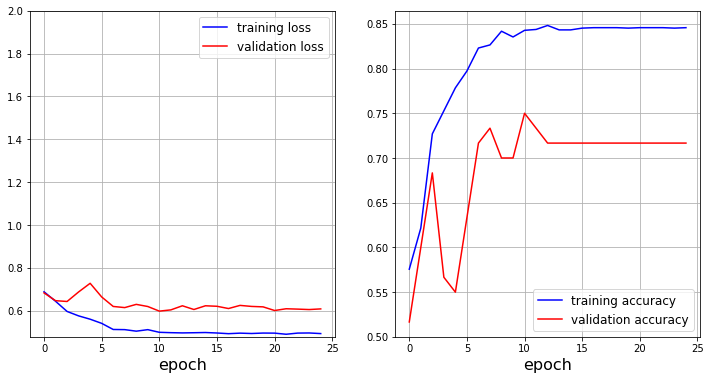

In [11]:
loss_train_list, loss_val_list, acc_train_list, acc_val_list = model_lists
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-r', label='validation accuracy')
ax[0].set_ylim(top=2)
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=12)
ax[0].grid(True)

ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=12)
ax[1].grid(True)

In [12]:
print("Training resnet18 from scratch:")
scratch_model = resnet18()
scratch_model.fc = nn.Linear(512,1) #replace classifier head
scratch_model.to(device)
scratch_model_lists = train_model(scratch_model, "resnet18_fromscratch.pt", l2_regularization=0.07, epochs=30)

Training resnet18 from scratch:
Train Epoch: 0 [1920/2022 (94%)]	Loss: 0.480584
epoch 0 training loss: 0.6592 acc: 71.27%
epoch 0 validation loss: 1.1952 acc: 51.67%
saved: resnet18_fromscratch.pt
Train Epoch: 1 [1920/2022 (94%)]	Loss: 0.365597
epoch 1 training loss: 0.4021 acc: 82.34%
epoch 1 validation loss: 2.8423 acc: 56.67%
saved: resnet18_fromscratch.pt
Train Epoch: 2 [1920/2022 (94%)]	Loss: 0.123339
epoch 2 training loss: 0.3269 acc: 86.30%
epoch 2 validation loss: 5.6968 acc: 50.00%
Train Epoch: 3 [1920/2022 (94%)]	Loss: 0.378593
epoch 3 training loss: 0.3164 acc: 86.45%
epoch 3 validation loss: 0.7798 acc: 70.00%
saved: resnet18_fromscratch.pt
Train Epoch: 4 [1920/2022 (94%)]	Loss: 0.388295
epoch 4 training loss: 0.2753 acc: 88.08%
epoch 4 validation loss: 4.1289 acc: 51.67%
Train Epoch: 5 [1920/2022 (94%)]	Loss: 0.286474
epoch 5 training loss: 0.3152 acc: 86.94%
epoch 5 validation loss: 0.4850 acc: 81.67%
saved: resnet18_fromscratch.pt
Train Epoch: 6 [1920/2022 (94%)]	Loss: 0

In [13]:
print("Fine tuning classifier of pre-trained resnet18 model:")
FT_model = resnet18()
FT_model.load_state_dict(torch.load("resnet18-5c106cde.pth")) #load parameters from ImageNet pretraining
for param in FT_model.parameters(): #freeze all layers
    param.requires_grad = False
FT_model.fc = nn.Linear(512,1) #replace classifier head
for param in FT_model.fc.parameters(): 
    param.requires_grad = True #make sure fc layer parameters can be updated
FT_model.to(device)

FT_model_lists = train_model(FT_model, "resnet18_pretrained.pt", initial_lr=5e-3, l2_regularization=0.06, epochs=30)

Fine tuning classifier of pre-trained resnet18 model:
Train Epoch: 0 [1920/2022 (94%)]	Loss: 0.258163
epoch 0 training loss: 0.5216 acc: 73.29%
epoch 0 validation loss: 0.4558 acc: 76.67%
saved: resnet18_pretrained.pt
Train Epoch: 1 [1920/2022 (94%)]	Loss: 0.317070
epoch 1 training loss: 0.3471 acc: 85.66%
epoch 1 validation loss: 0.4127 acc: 80.00%
saved: resnet18_pretrained.pt
Train Epoch: 2 [1920/2022 (94%)]	Loss: 0.200543
epoch 2 training loss: 0.3142 acc: 87.04%
epoch 2 validation loss: 0.5249 acc: 80.00%
saved: resnet18_pretrained.pt
Train Epoch: 3 [1920/2022 (94%)]	Loss: 0.243198
epoch 3 training loss: 0.3533 acc: 84.47%
epoch 3 validation loss: 0.3972 acc: 81.67%
saved: resnet18_pretrained.pt
Train Epoch: 4 [1920/2022 (94%)]	Loss: 0.152045
epoch 4 training loss: 0.2754 acc: 88.38%
epoch 4 validation loss: 0.4346 acc: 83.33%
saved: resnet18_pretrained.pt
Train Epoch: 5 [1920/2022 (94%)]	Loss: 0.400277
epoch 5 training loss: 0.2612 acc: 89.02%
epoch 5 validation loss: 0.3840 acc:

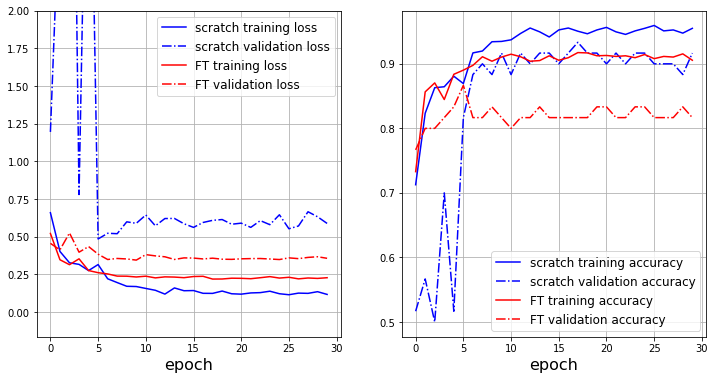

In [14]:
loss_train_list, loss_val_list, acc_train_list, acc_val_list = scratch_model_lists
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='scratch training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-.b', label='scratch validation loss')


ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='scratch training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-.b', label='scratch validation accuracy')

loss_train_list, loss_val_list, acc_train_list, acc_val_list = FT_model_lists
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-r', label='FT training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-.r', label='FT validation loss')

ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-r', label='FT training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-.r', label='FT validation accuracy')

ax[0].set_ylim(top=2)
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=12)
ax[0].grid(True)

ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=12)
ax[1].grid(True)

In [15]:
load_checkpoint("custom_model.pt", model, None, device)
loss_test, acc_test = test(model, test_loader, device)
print('custom model:')
print('test loss: %0.4f' % (loss_test))
print('test accuracy: %2.2f%%' % (acc_test*100))

custom model:
test loss: 0.5384
test accuracy: 80.75%


In [16]:
load_checkpoint("resnet18_fromscratch.pt", scratch_model, None, device)
loss_test, acc_test = test(scratch_model, test_loader, device)
print('Resnet18 trained from scratch:')
print('test loss: %0.4f' % (loss_test))
print('test accuracy: %2.2f%%' % (acc_test*100))

load_checkpoint("resnet18_pretrained.pt", FT_model, None, device)
loss_test, acc_test = test(FT_model, test_loader, device)
print('\nPretrained network:')
print('test loss: %0.4f' % (loss_test))
print('test accuracy: %2.2f%%' % (acc_test*100))

Resnet18 trained from scratch:
test loss: 0.2093
test accuracy: 91.75%

Pretrained network:
test loss: 0.3508
test accuracy: 84.75%


It doesn't seem that using a pretrained network offers better performance. My first hypothesis was to attribute this to the fact that ImageNet, which the network is trained on, is not a medical image dataset. The filters learned by the ResNet18 when pretrained on that dataset may not apply well to the COVID-19 images dataset since the datasets are very different.    
However, then I found this paper: https://openaccess.thecvf.com/content_ECCVW_2018/papers/11134/Xie_Pre-training_on_Grayscale_ImageNet_Improves_Medical_Image_Classification_ECCVW_2018_paper.pdf    
The authors hypothesize that the difference is the number of channels in the input. The medical images here are single-channel, but the ResNet18 is trained on color images with 3 channels. So, the filters learned by the ResNet18 from color images may not be useful on grayscale images. The authors see success when they pretrain on a grayscale version of the ImageNet data, and it's likely that the same approach could work here.